In [1]:
import os
import sys
from collections import Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
#from torchmetrics import F1Score, Accuracy
from transformers import BertTokenizer, BertForSequenceClassification, get_cosine_schedule_with_warmup, AdamW

from sklearn.model_selection import train_test_split
import plotly.figure_factory as ff
from matplotlib import pyplot as plt
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    accuracy_score,
    multilabel_confusion_matrix,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_score,
    recall_score,
)

In [2]:
MODEL_ID = 1
TEST_SIZE = 0.2
VAL_SIZE = 0.2

In [3]:
df = pd.read_csv(r"C:\Users\vsevo\MKN\skillbox_nlp-vsevolod-lavrov\data\practice_cleaned.csv")
df

,Направление,Факультет,ID студента,Оценка,Категория,Тег,Комментарий,Статус
0,C,113.0,1493.0,1.0,Видео,VP2,Видео лагает,NaN
1,C,113.0,5580.0,5.0,ДЗ,H3 D,Торгом Бабаян! Спасибо вам большое за помощь в...,NaN
2,E,126.0,5619.0,5.0,ДЗ,H3,Спасибо),NaN
3,E,123.0,310.0,3.0,ДЗ,H2 E1,комментарий содержит нерелевантную информацию ...,NaN
4,E,123.0,1913.0,5.0,ДЗ,H3 D,"Жонибек, хочу Вас поблагодарить за ваши советы...",NaN
...,...,...,...,...,...,...,...,...
56124,Z,133.0,NaN,3.0,ДЗ,H2,требуемый формат иконок платный,NaN
56125,Z,NaN,NaN,0.0,NaN,S1,заплатила и дальше просто никому нет дела поче...,NaN
56126,Z,NaN,NaN,7.0,NaN,LMS,Крайне раздражают некоторые детали)\nНапример ...,NaN
56127,Z,NaN,NaN,NaN,NaN,VC2 VP2,321.Профессия Бизнес-аналитик\nАналитик данных...,NaN


In [4]:
def process_data(df):
    df = df[(df['Категория'] != "Качество материалов") & (df['Категория'] != "Интерфейс платформы") & (df['Категория'] != "Общение с куратором")]
    df = df[['Категория', 'Комментарий']].dropna()
    rename = {
        'Категория': 'category',
        'Комментарий': 'text'
    }
    df = df.rename(columns=rename)
    return df



In [5]:
df = process_data(df)
df
    

,category,text
0,Видео,Видео лагает
1,ДЗ,Торгом Бабаян! Спасибо вам большое за помощь в...
2,ДЗ,Спасибо)
3,ДЗ,комментарий содержит нерелевантную информацию ...
4,ДЗ,"Жонибек, хочу Вас поблагодарить за ваши советы..."
...,...,...
56119,Видео,"Отличная подача, содержание. Спасибо"
56120,Видео,"Урок длинный, информация в целом полезная, но ..."
56121,ДЗ,Задание 4 поняла что нужно дополнить в том что...
56123,ДЗ,Очень рада познакомится 😉\nМой профессиональны...


In [6]:

CLASSES = list(df['category'].unique())
CLASSES

['Видео', 'ДЗ', 'Лонгрид', 'Тест']

In [7]:
train, test = train_test_split(df, test_size=TEST_SIZE, random_state=1337)

### Manual cleaning of text from job offers and advertisements


In [8]:
# train['text_length'] = train['text'].apply(len)
# test['text_length'] = test['text'].apply(len)

# train['occurrence'] = train['text'].map(dict(Counter(train['text'].to_list())))
# test['occurrence'] = test['text'].map(dict(Counter(test['text'].to_list())))


# train

In [9]:
labels = dict(zip(CLASSES, range(len(CLASSES))))

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
       
        self.labels = [labels[label] for label in df['category']]
   
            
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
      
        return len(self.labels)
       

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])
    
    def get_batch_oid(self, idx):
        return np.array(self.oid[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)
        return batch_texts, batch_y
       
   

In [10]:
class BertClassifier(nn.Module):
    def __init__(self, model_path, tokenizer_path, data, n_classes=len(CLASSES), epochs=4):
        super().__init__()
        self.model = BertForSequenceClassification.from_pretrained(model_path)
        self.tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
        self.data = data
        self.device = torch.device('cuda')
        self.max_len = 512
        self.epochs = epochs
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes).cuda()
        self.model = self.model.cuda()

    
    def preparation(self):
        self.df_train, self.df_val = train_test_split(self.data, test_size=VAL_SIZE, random_state=1337)
        
        self.train = CustomDataset(self.df_train, self.tokenizer)
        self.val = CustomDataset(self.df_val, self.tokenizer)
        
        self.train_dataloader = torch.utils.data.DataLoader(self.train, batch_size=4, shuffle=True)
        self.val_dataloader = torch.utils.data.DataLoader(self.val, batch_size=4)
    
       
        self.optimizer = AdamW(self.model.parameters(), lr=2e-5, correct_bias=False)
        self.scheduler = get_cosine_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=0,
                num_training_steps=len(self.train_dataloader) * self.epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().cuda()
            
    def fit(self):
        self.model = self.model.train()
        
        for epoch_num in range(self.epochs):
            total_acc_train = 0
            total_loss_train = 0
            for train_input, train_label in tqdm(self.train_dataloader):
                train_label = train_label.cuda()
                mask = train_input['attention_mask'].cuda()
                input_id = train_input['input_ids'].squeeze(1).cuda()
                output = self.model(input_id.cuda(), mask.cuda())

                batch_loss = self.loss_fn(output[0], train_label.long())
                total_loss_train += batch_loss.item()

                acc = (output[0].argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                self.model.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                self.scheduler.step()
            total_acc_val, total_loss_val = self.eval()
           
            print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(self.df_train): .3f} \
            | Train Accuracy: {total_acc_train / len(self.df_train): .3f} \
            | Val Loss: {total_loss_val / len(self.df_val): .3f} \
            | Val Accuracy: {total_acc_val / len(self.df_val): .3f}')

            
            os.makedirs('checkpoint', exist_ok=True)
            torch.save(self.model, f'checkpoint/model_{MODEL_ID}_epoch_{epoch_num}.pt')
        os.makedirs('models', exist_ok=True)
        torch.save(self.model, f'models/model_{MODEL_ID}.pt')

        return total_acc_train, total_loss_train
    
    def eval(self):
        self.model = self.model.eval()
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():
            for val_input, val_label in tqdm(self.val_dataloader):
                val_label = val_label.cuda()
                mask = val_input['attention_mask'].cuda()
                input_id = val_input['input_ids'].squeeze(1).cuda() 

                output = self.model(input_id.to('cuda'), mask.to('cuda'))

                batch_loss = self.loss_fn(output[0], val_label.long())
                total_loss_val += batch_loss.item()

                acc = (output[0].argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
            
        return total_acc_val, total_loss_val
    

In [11]:
model_path = 'cointegrated/rubert-tiny'
tokenizer_path = 'cointegrated/rubert-tiny'

In [12]:
bert_tiny = BertClassifier(model_path, tokenizer_path, train, epochs=4)
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)
bert_tiny.preparation()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cointegrated/rubert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\vsevo\MKN\skillbox-practice-vsevolod-lavrov\.pixi\env\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
bert_tiny.fit()

100%|██████████| 1932/1932 [00:34<00:00, 56.73it/s]


Epochs: 1 | Train Loss:  0.136             | Train Accuracy:  0.808             | Val Loss:  0.127             | Val Accuracy:  0.814


100%|██████████| 1932/1932 [00:34<00:00, 55.45it/s]


Epochs: 2 | Train Loss:  0.111             | Train Accuracy:  0.844             | Val Loss:  0.122             | Val Accuracy:  0.820


100%|██████████| 1932/1932 [00:35<00:00, 53.89it/s]


Epochs: 3 | Train Loss:  0.093             | Train Accuracy:  0.873             | Val Loss:  0.125             | Val Accuracy:  0.824


100%|██████████| 1932/1932 [00:35<00:00, 54.30it/s]


Epochs: 4 | Train Loss:  0.081             | Train Accuracy:  0.892             | Val Loss:  0.128             | Val Accuracy:  0.824


(27564, 2493.4893857243005)

In [15]:
test_dataset = CustomDataset(test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=16)

In [16]:
def predict(logits: torch.Tensor) -> np.ndarray:
    """Helper function for predictions calculating.

    Args:
        logits (torch.Tensor): model's raw output

    Returns:
        np.ndarray: array with predicted class id.
    """
    s = torch.nn.Softmax()
    probs = s(torch.tensor(logits))
    return np.argmax(probs)

In [17]:
preds_logits = torch.tensor([])
targets = torch.tensor([])

with torch.no_grad():
    for val_input, val_label in tqdm(test_dataloader):
        mask = val_input['attention_mask'].cuda()
        input_id = val_input['input_ids'].squeeze(1).cuda()
        output = bert_tiny.model(input_id, mask)[0].cpu()
        preds_logits = torch.cat((preds_logits, output))
        targets = torch.cat((targets, val_label.long().cpu()))



100%|██████████| 604/604 [00:41<00:00, 14.42it/s]


In [18]:
preds = np.apply_along_axis(predict, 1, preds_logits)
preds

c:\Users\vsevo\MKN\skillbox-practice-vsevolod-lavrov\.pixi\env\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


array([1, 0, 0, ..., 1, 1, 1], dtype=int64)

In [24]:
cr = classification_report(targets, preds, target_names=CLASSES, output_dict=True)
cr = pd.DataFrame(cr).T
os.makedirs(f'..\models_metrics', exist_ok=True)
cr.to_csv(f"..\models_metrics\model_{MODEL_ID}_metrics.csv")
print(cr)

              precision    recall  f1-score      support
Видео          0.806296  0.874972  0.839231  4391.000000
ДЗ             0.867593  0.864777  0.866183  4622.000000
Лонгрид        0.234375  0.036855  0.063694   407.000000
Тест           0.693694  0.647059  0.669565   238.000000
accuracy       0.829157  0.829157  0.829157     0.829157
macro avg      0.650489  0.605916  0.609668  9658.000000
weighted avg   0.808754  0.829157  0.815266  9658.000000


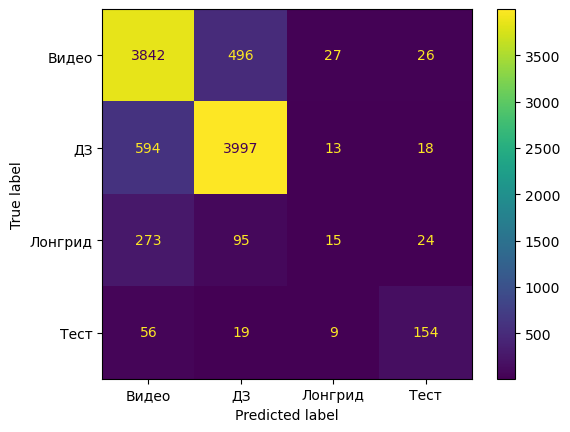

In [23]:
x, y = CLASSES, list(reversed(CLASSES))

cm = confusion_matrix(targets, preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix =cm, display_labels=CLASSES)


cm_display.plot()
plt.savefig(f"../models_metrics/model_{MODEL_ID}_heatmap.png")
plt.show()